In [9]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False
})

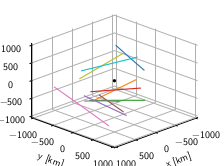

In [10]:
passes_df = pd.read_pickle('Telesat_0_7day.pkl')

N_passes = 10
passes_df = passes_df[0:N_passes]

fig = plt.figure(figsize=(3.2, 2.4))
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

for n in range(N_passes):
    pass_df = passes_df.iloc[n]
    r_ab = (pass_df.rr_a - pass_df.rr_b)/1000
    x, y, z = r_ab[:,0], r_ab[:,1], r_ab[:,2]
    line, = ax.plot(x, y, z, linewidth=1.125)

ax.scatter(0, 0, 0, s=20, c='#000000', marker='.', )
   
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim((-1000, 1000))
ax.set_ylim((-1000, 1000))
ax.set_zlim((-1000, 1000))
ax.view_init(30, 45)

plt.grid()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/passes_irf.pgf')

fig

In [19]:
import quaternion as qn

qq = [None] * len(passes_df)
ll = [None] * len(passes_df)

# Todo make this properly vectorized
for i, pass_df in passes_df.iterrows():
    rr_a = pass_df.rr_a
    rr_ab = pass_df.rr_a - pass_df.rr_b
    
    # Start by finding the rotation of the sc in the ECIF
    xxyyzz = np.cross(rr_a, rr_ab) # Assume Zenith pointing (z-axis is in line with rr_a)
    xx, yy, zz = xxyyzz[:,0], xxyyzz[:,1], xxyyzz[:,2]
    ww = np.sqrt(np.linalg.norm(rr_a, axis=1) ** 2 * np.linalg.norm(rr_a, axis=1)**2) + np.sum(rr_a*rr_ab, axis=1)
    nn = np.sqrt(xx**2 + yy**2 + zz**2 + ww**2)
    
    qq[i] = qn.as_quat_array(np.array([xx, yy, zz, ww]).T) / nn
 
    # Old option (rotate z unit vector to point to data relay)
    # rotate vectors is somewhat slow, see https://quaternion.readthedocs.io/en/latest/_autosummary/quaternion.html?highlight=rotate#quaternion.rotate_vectors
    ll[i] = np.linalg.norm(rr_ab, axis=1)[:, np.newaxis] * qn.rotate_vectors(qq[i], [0,0,1])
   
 
passes_df['qq'] = qq
passes_df['ll'] = ll

D:\git\hermes-optimization\cenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


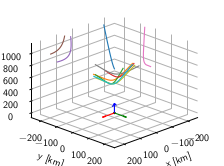

In [62]:
fig = plt.figure(figsize=(3.2, 2.4))
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

for i, pass_df in passes_df.head(N_passes).iterrows():
    ll = pass_df.ll/1000
    x, y, z = ll[:,0], ll[:,1], ll[:,2]
    line, = ax.plot(x, y, z, linewidth=1.125)

#ax.scatter(0, 0, 0, s=20, c='#000000', marker='.', )

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(np.array([-1, 1]) * 250)
ax.set_ylim(np.array([-1, 1]) * 250)
# ax.set_zlim((-100, 100))
ax.view_init(30, 45)

per = 0.3
u = ax.get_xlim()[1]*per
v = ax.get_ylim()[1]*per
w = ax.get_zlim()[1]*per*0.5

# Plot coordinate system
ax.quiver(0,0,0, u,0,0, length=1, normalize=False, linewidth=1.125, color = 'r')
ax.quiver(0,0,0, 0,v,0, length=1, normalize=False, linewidth=1.125, color = 'g')
ax.quiver(0,0,0, 0,0,w, length=1, normalize=False, linewidth=1.125, color = 'b')
ax.scatter(0, 0, 0, s=10, c='#000000', marker='.', )

plt.grid()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/passes_scf.pgf')

fig